In [4]:
import pandas as pd
import numpy as np
from collections import defaultdict
from geopy.distance import geodesic
import matplotlib.pyplot as plt

def build_route_dict(historical_df):
    """
    Build a dictionary of routes from the historical DataFrame.

    Parameters
    ----------
    historical_df : pd.DataFrame
        DataFrame containing columns: ["Route_ID", "timestamp", "latitude", "longitude"].

    Returns
    -------
    dict
        A dictionary mapping route_id -> list of (timestamp, latitude, longitude),
        sorted by timestamp.
    """
    route_dict = defaultdict(list)
    
    # Convert timestamp to datetime if not already
    if not np.issubdtype(historical_df["timestamp"].dtype, np.datetime64):
        historical_df["timestamp"] = pd.to_datetime(historical_df["timestamp"])
    
    # Group data by Route_ID and build list of points
    for idx, row in historical_df.iterrows():
        rid = row["Route_ID"]
        t = row["timestamp"]
        lat = row["latitude"]
        lon = row["longitude"]
        route_dict[rid].append((t, lat, lon))
        
    # Sort each route's points by timestamp
    for rid in route_dict:
        route_dict[rid].sort(key=lambda x: x[0])
    
    return route_dict


def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the geodesic distance between two lat-lon points using geopy.
    
    Parameters
    ----------
    lat1, lon1, lat2, lon2 : float
        Coordinates in degrees.

    Returns
    -------
    float
        Distance in meters between the two points.
    """
    return geodesic((lat1, lon1), (lat2, lon2)).meters


def find_closest_point_on_route(pallet_lat, pallet_lon, pallet_time, route_points):
    """
    Find the closest point (in space-time) on a single route to the given pallet location/time.

    Parameters
    ----------
    pallet_lat : float
        Latitude of the pallet.
    pallet_lon : float
        Longitude of the pallet.
    pallet_time : pd.Timestamp
        Timestamp at which we're matching the pallet.
    route_points : list of (pd.Timestamp, float, float)
        Sorted list of route points.

    Returns
    -------
    tuple
        (min_dist, best_point)
        min_dist : float
            The minimal distance (in meters) found.
        best_point : tuple or None
            The best matching point as (interp_lat, interp_lon, pallet_time).
            Could be None if no route segment spans the pallet_time range.
    """
    min_dist = float('inf')
    best_point = None
    
    # If route_points is empty or has only 1 point, cannot interpolate
    if len(route_points) < 2:
        return min_dist, best_point

    # Loop through consecutive pairs of points to find time range
    for i in range(len(route_points) - 1):
        t1, lat1, lon1 = route_points[i]
        t2, lat2, lon2 = route_points[i+1]
        
        # Check if our pallet_time lies between t1 and t2
        if t1 <= pallet_time <= t2:
            total_diff = (t2 - t1).total_seconds()
            if total_diff == 0:
                # Avoid division by zero
                interp_lat, interp_lon = lat1, lon1
            else:
                # Linear interpolation in time
                elapsed = (pallet_time - t1).total_seconds()
                ratio = elapsed / total_diff
                interp_lat = lat1 + ratio * (lat2 - lat1)
                interp_lon = lon1 + ratio * (lon2 - lon1)
            
            dist = haversine_distance(pallet_lat, pallet_lon, interp_lat, interp_lon)
            if dist < min_dist:
                min_dist = dist
                best_point = (interp_lat, interp_lon, pallet_time)
    
    return min_dist, best_point


def match_pallet_to_route(pallet_lat, pallet_lon, pallet_time, route_dict):
    """
    Match the pallet's position/time to the best route.

    Parameters
    ----------
    pallet_lat : float
        Pallet latitude.
    pallet_lon : float
        Pallet longitude.
    pallet_time : pd.Timestamp
        Pallet timestamp.
    route_dict : dict
        {route_id -> [(timestamp, lat, lon), ...]}

    Returns
    -------
    tuple
        (best_route_id, min_dist_global, best_route_point)
    """
    best_route_id = None
    min_dist_global = float('inf')
    best_route_point = None
    
    for route_id, route_points in route_dict.items():
        dist, point = find_closest_point_on_route(pallet_lat, pallet_lon, pallet_time, route_points)
        if dist < min_dist_global:
            min_dist_global = dist
            best_route_id = route_id
            best_route_point = point

    return best_route_id, min_dist_global, best_route_point


def predict_next_location(route_id, current_time, route_dict):
    """
    Predict the next location for the given route and time.

    Parameters
    ----------
    route_id : str
        The route ID to use.
    current_time : pd.Timestamp
        The time from which we want the next point.
    route_dict : dict
        {route_id -> [(timestamp, lat, lon), ...]}

    Returns
    -------
    tuple
        (next_timestamp, next_lat, next_lon)
        If current_time is beyond the last route point, returns the last route point.
    """
    route_points = route_dict[route_id]
    # Find the first route point whose timestamp > current_time
    for (t, lat, lon) in route_points:
        if t > current_time:
            return (t, lat, lon)
    # If we're at or past the end, return the last point
    return route_points[-1]


def plot_routes_and_pallets(historical_df, ongoing_df, violated_df=None):
    """
    Simple visualization of routes (in gray) and ongoing pallet points (in blue),
    and optionally the violated points (in red) if a violations DataFrame is given.
    
    Parameters
    ----------
    historical_df : pd.DataFrame
        DataFrame with ["Route_ID", "timestamp", "latitude", "longitude"].
    ongoing_df : pd.DataFrame
        DataFrame with ["Pallet_ID", "timestamp", "latitude", "longitude"].
    violated_df : pd.DataFrame or None
        DataFrame with the deviated points, optional. Expected columns at least:
        ["Pallet_ID", "timestamp", "latitude", "longitude", "dist", "Route_ID"].
    """
    plt.figure(figsize=(8, 6))
    
    # Plot historical routes (in gray)
    # A route might be multiple points. We'll group by Route_ID and plot lines.
    for route_id, group in historical_df.groupby("Route_ID"):
        plt.plot(group["longitude"], group["latitude"], color="gray", alpha=0.5, linewidth=1)
    
    # Plot ongoing pallets (in blue)
    plt.scatter(ongoing_df["longitude"], ongoing_df["latitude"], 
                color="blue", s=10, alpha=0.6, label="Pallet")
    
    # If violations DataFrame is provided, plot them in red
    if violated_df is not None and not violated_df.empty:
        plt.scatter(violated_df["longitude"], violated_df["latitude"], 
                    color="red", s=15, alpha=0.8, marker="x", label="Violation")
    
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Routes and Pallet Movements")
    plt.legend()
    plt.show()


def main():
    """
    Main function to demonstrate:
    1. Building route_dict from historical_data
    2. Iterating over ongoing_data to match routes, detect deviations, predict next location
    3. Storing deviation results
    4. Visualizing routes and pallet data
    """

    # -------------------------------------
    # 1. Load or assume historical_data and ongoing_data are given
    # -------------------------------------
    # For example, if reading from CSV:
    historical_data = pd.read_csv("known_route_repo.csv")
    ongoing_data = pd.read_csv("On-going trip data.csv")

    # For illustration, let's assume you already have them as DataFrames:
    # historical_data.info() and ongoing_data.info() from your logs:
    # We'll just use them directly here.

    # historical_data and ongoing_data must have these columns:
    # historical_data: ["Route_ID", "timestamp", "latitude", "longitude"]
    # ongoing_data:    ["Pallet_ID", "timestamp", "latitude", "longitude"]

    # Convert timestamps to datetime
    historical_data["timestamp"] = pd.to_datetime(historical_data["timestamp"])
    ongoing_data["timestamp"] = pd.to_datetime(ongoing_data["timestamp"])

    # -------------------------------------
    # 2. Build route_dict from historical_data
    # -------------------------------------
    route_dict = build_route_dict(historical_data)

    # -------------------------------------
    # 3. Define threshold and iterate over ongoing_data
    # -------------------------------------
    threshold = 50  # meters (example)
    
    violations = []  # We'll store pallet rows that deviate beyond threshold

    # We'll create a list of results (for demonstration)
    results = []

    for idx, pallet_row in ongoing_data.iterrows():
        pid = pallet_row["Pallet_ID"]
        plat = pallet_row["latitude"]
        plon = pallet_row["longitude"]
        ptime = pallet_row["timestamp"]
        
        # Match to route
        route_id, dist, best_route_point = match_pallet_to_route(plat, plon, ptime, route_dict)

        # Check deviation
        if dist > threshold:
            # Store violation info
            violations.append({
                "Pallet_ID": pid,
                "timestamp": ptime,
                "latitude": plat,
                "longitude": plon,
                "dist": dist,
                "Route_ID": route_id
            })
        
        # Predict next location
        next_t, next_lat, next_lon = predict_next_location(route_id, ptime, route_dict)
        
        results.append({
            "Pallet_ID": pid,
            "timestamp": ptime,
            "latitude": plat,
            "longitude": plon,
            "matched_route": route_id,
            "distance_to_route": dist,
            "next_timestamp": next_t,
            "next_lat": next_lat,
            "next_lon": next_lon
        })

    # -------------------------------------
    # 4. Convert results and violations to DataFrames
    # -------------------------------------
    results_df = pd.DataFrame(results)
    violations_df = pd.DataFrame(violations)

    # Example: Save violations to CSV
    violations_df.to_csv("violations.csv", index=False)

    # -------------------------------------
    # 5. Visualization
    # -------------------------------------
    # We'll call our helper function to show:
    # - Historical routes in gray
    # - Ongoing pallet points in blue
    # - Violations in red (x)
    plot_routes_and_pallets(historical_data, ongoing_data, violations_df)

    # Optionally, show some summary
    print(f"Total pallets processed: {len(ongoing_data)}")
    print(f"Total violations: {len(violations_df)}")


if __name__ == "__main__":
     main()




IndexError: list index out of range

FileNotFoundError: [Errno 2] No such file or directory: 'historical_data.csv'

Exported 625 unique pallet-to-route assignments to pallet_route_mapping.csv


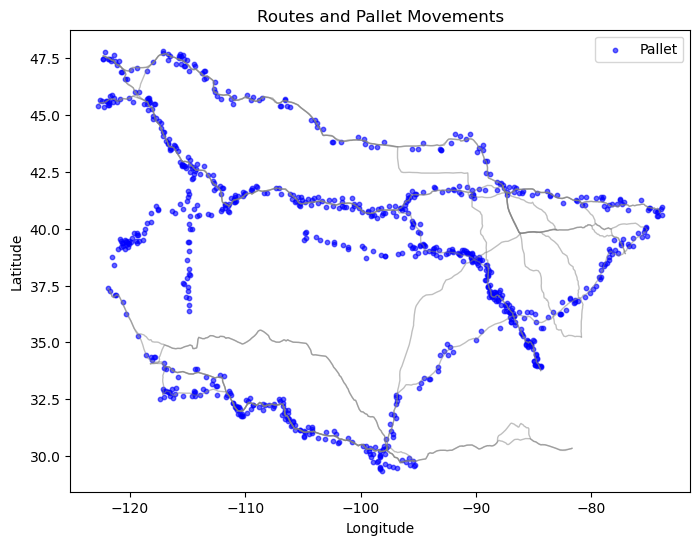

Total pallet records processed: 851
Total violations: 0


In [7]:
import pandas as pd
import numpy as np
from collections import defaultdict
from geopy.distance import geodesic
import matplotlib.pyplot as plt

def build_route_dict(historical_df):
    """
    Build a dictionary of routes from the historical DataFrame.

    Parameters
    ----------
    historical_df : pd.DataFrame
        DataFrame containing columns: ["Route_ID", "timestamp", "latitude", "longitude"].

    Returns
    -------
    dict
        A dictionary mapping route_id -> list of (timestamp, latitude, longitude),
        sorted by timestamp.
    """
    route_dict = defaultdict(list)
    
    # Convert timestamp to datetime if not already
    if not np.issubdtype(historical_df["timestamp"].dtype, np.datetime64):
        historical_df["timestamp"] = pd.to_datetime(historical_df["timestamp"])
    
    # Group data by Route_ID and build list of points
    for idx, row in historical_df.iterrows():
        rid = row["Route_ID"]
        t = row["timestamp"]
        lat = row["latitude"]
        lon = row["longitude"]
        route_dict[rid].append((t, lat, lon))
        
    # Sort each route's points by timestamp
    for rid in route_dict:
        route_dict[rid].sort(key=lambda x: x[0])
    
    return route_dict

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the geodesic distance between two lat-lon points using geopy.
    
    Parameters
    ----------
    lat1, lon1, lat2, lon2 : float
        Coordinates in degrees.

    Returns
    -------
    float
        Distance in meters between the two points.
    """
    return geodesic((lat1, lon1), (lat2, lon2)).meters

def find_closest_point_on_route(pallet_lat, pallet_lon, pallet_time, route_points):
    """
    Find the closest point (in space-time) on a single route to the given pallet location/time.

    Parameters
    ----------
    pallet_lat : float
        Latitude of the pallet.
    pallet_lon : float
        Longitude of the pallet.
    pallet_time : pd.Timestamp
        Timestamp at which we're matching the pallet.
    route_points : list of (pd.Timestamp, float, float)
        Sorted list of route points.

    Returns
    -------
    tuple
        (min_dist, best_point)
        min_dist : float
            The minimal distance (in meters) found.
        best_point : tuple or None
            The best matching point as (interp_lat, interp_lon, pallet_time).
            Could be None if no route segment spans the pallet_time range, 
            or if route_points is too short for interpolation.
    """
    min_dist = float('inf')
    best_point = None
    
    # If route_points is empty or has only 1 point, cannot interpolate in time
    if len(route_points) < 2:
        return min_dist, best_point

    # Loop through consecutive pairs of points to find time range
    for i in range(len(route_points) - 1):
        t1, lat1, lon1 = route_points[i]
        t2, lat2, lon2 = route_points[i+1]
        
        # Check if our pallet_time lies between t1 and t2
        if t1 <= pallet_time <= t2:
            total_diff = (t2 - t1).total_seconds()
            if total_diff == 0:
                # Avoid division by zero
                interp_lat, interp_lon = lat1, lon1
            else:
                # Linear interpolation in time
                elapsed = (pallet_time - t1).total_seconds()
                ratio = elapsed / total_diff
                interp_lat = lat1 + ratio * (lat2 - lat1)
                interp_lon = lon1 + ratio * (lon2 - lon1)
            
            dist = haversine_distance(pallet_lat, pallet_lon, interp_lat, interp_lon)
            if dist < min_dist:
                min_dist = dist
                best_point = (interp_lat, interp_lon, pallet_time)
    
    return min_dist, best_point

def match_pallet_to_route(pallet_lat, pallet_lon, pallet_time, route_dict):
    """
    Match the pallet's position/time to the best route.

    Parameters
    ----------
    pallet_lat : float
        Pallet latitude.
    pallet_lon : float
        Pallet longitude.
    pallet_time : pd.Timestamp
        Pallet timestamp.
    route_dict : dict
        {route_id -> [(timestamp, lat, lon), ...]}

    Returns
    -------
    tuple
        (best_route_id, min_dist_global, best_route_point)
        best_route_id : str or None
            The route that yielded the smallest distance, or None if no route is found.
        min_dist_global : float
            The smallest distance found across all routes.
        best_route_point : tuple or None
            The closest interpolated point (lat, lon, time), or None if none found.
    """
    best_route_id = None
    min_dist_global = float('inf')
    best_route_point = None
    
    for route_id, route_points in route_dict.items():
        dist, point = find_closest_point_on_route(pallet_lat, pallet_lon, pallet_time, route_points)
        if dist < min_dist_global:
            min_dist_global = dist
            best_route_id = route_id
            best_route_point = point

    return best_route_id, min_dist_global, best_route_point

def predict_next_location(route_id, current_time, route_dict):
    """
    Predict the next location for the given route and time.

    Parameters
    ----------
    route_id : str
        The route ID to use.
    current_time : pd.Timestamp
        The time from which we want the next point.
    route_dict : dict
        {route_id -> [(timestamp, lat, lon), ...]}

    Returns
    -------
    tuple
        (next_timestamp, next_lat, next_lon)
        If current_time is beyond the last route point or the route is empty,
        returns (None, None, None).
    """
    route_points = route_dict.get(route_id, [])
    # If route_points is empty or None, return fallback
    if not route_points:
        return (None, None, None)

    # Find the first route point whose timestamp > current_time
    for (t, lat, lon) in route_points:
        if t > current_time:
            return (t, lat, lon)
    # If we're at or past the end, return the last point
    # (but route_points is guaranteed non-empty at this point)
    return route_points[-1]

def plot_routes_and_pallets(historical_df, ongoing_df, violated_df=None):
    """
    Simple visualization of routes (in gray) and ongoing pallet points (in blue),
    and optionally the violated points (in red) if a violations DataFrame is given.
    
    Parameters
    ----------
    historical_df : pd.DataFrame
        DataFrame with ["Route_ID", "timestamp", "latitude", "longitude"].
    ongoing_df : pd.DataFrame
        DataFrame with ["Pallet_ID", "timestamp", "latitude", "longitude"].
    violated_df : pd.DataFrame or None
        DataFrame with the deviated points, optional. 
        Expected columns: ["Pallet_ID", "timestamp", "latitude", "longitude", "dist", "Route_ID"].
    """
    plt.figure(figsize=(8, 6))
    
    # Plot historical routes (in gray) by grouping them
    for route_id, group in historical_df.groupby("Route_ID"):
        # Sort by timestamp to get a properly connected route line
        group_sorted = group.sort_values("timestamp")
        plt.plot(group_sorted["longitude"], group_sorted["latitude"], 
                 color="gray", alpha=0.5, linewidth=1)
    
    # Plot ongoing pallet points (in blue)
    plt.scatter(ongoing_df["longitude"], ongoing_df["latitude"], 
                color="blue", s=10, alpha=0.6, label="Pallet")
    
    # If violations DataFrame is provided, plot them in red
    if violated_df is not None and not violated_df.empty:
        plt.scatter(violated_df["longitude"], violated_df["latitude"], 
                    color="red", s=15, alpha=0.8, marker="x", label="Violation")
    
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Routes and Pallet Movements")
    plt.legend()
    plt.show()

def export_pallet_to_route_mapping(results_df, output_file="pallet_route_mapping.csv"):
    """
    Export a CSV showing which Pallet_ID is matched to which Route_ID,
    along with any other fields you want to keep.

    Parameters
    ----------
    results_df : pd.DataFrame
        The DataFrame produced by your main loop, 
        which has columns: ["Pallet_ID", "matched_route", ...].
    output_file : str
        The filename/path for the output CSV.
    """
    # Rename matched_route to Route_ID for clarity
    mapping_df = results_df.rename(columns={"matched_route": "Route_ID"})

    # Keep only relevant columns if you want
    # mapping_df = mapping_df[["Pallet_ID", "Route_ID", "distance_to_route"]]

    # Drop duplicates
    mapping_df = mapping_df.drop_duplicates(subset=["Pallet_ID", "Route_ID"])

    mapping_df.to_csv(output_file, index=False)
    print(f"Exported {len(mapping_df)} unique pallet-to-route assignments to {output_file}")

def main():
    # -------------------------------------
    # 1. Load CSV data into DataFrames
    # -------------------------------------
    historical_data = pd.read_csv("known_route_repo.csv")
    ongoing_data = pd.read_csv("On-going trip data.csv")

    historical_data["timestamp"] = pd.to_datetime(historical_data["timestamp"])
    ongoing_data["timestamp"] = pd.to_datetime(ongoing_data["timestamp"])

    # 2. Build route dict
    route_dict = build_route_dict(historical_data)

    threshold = 150  # meters
    violations = []
    results = []

    for idx, row in ongoing_data.iterrows():
        pid = row["Pallet_ID"]
        plat = row["latitude"]
        plon = row["longitude"]
        ptime = row["timestamp"]

        route_id, dist, best_route_point = match_pallet_to_route(plat, plon, ptime, route_dict)

        # If you suspect everything might be inf, debug here:
        # print(pid, ptime, route_id, dist)

        # If all routes had dist=inf, route_id might remain the last route from the dict.
        # Let's force it to None if dist==inf:
        if dist == float('inf'):
            route_id = None

        if route_id is None:
            # No valid route found
            results.append({
                "Pallet_ID": pid,
                "timestamp": ptime,
                "latitude": plat,
                "longitude": plon,
                "matched_route": None,
                "distance_to_route": np.nan,
                "next_timestamp": None,
                "next_lat": None,
                "next_lon": None
            })
            continue

        # If dist is bigger than threshold => violation
        if dist > threshold:
            violations.append({
                "Pallet_ID": pid,
                "timestamp": ptime,
                "latitude": plat,
                "longitude": plon,
                "dist": dist,
                "Route_ID": route_id
            })

        next_t, next_lat, next_lon = predict_next_location(route_id, ptime, route_dict)

        results.append({
            "Pallet_ID": pid,
            "timestamp": ptime,
            "latitude": plat,
            "longitude": plon,
            "matched_route": route_id,
            "distance_to_route": dist,
            "next_timestamp": next_t,
            "next_lat": next_lat,
            "next_lon": next_lon
        })

    results_df = pd.DataFrame(results)
    violations_df = pd.DataFrame(violations)

    # 3. Export extra CSV: which Pallet is on which Route
    export_pallet_to_route_mapping(results_df, "pallet_route_mapping.csv")

    # 4. Save the full results and violations
    results_df.to_csv("full_results.csv", index=False)
    violations_df.to_csv("violations.csv", index=False)

    plot_routes_and_pallets(historical_data, ongoing_data, violations_df)

    print(f"Total pallet records processed: {len(ongoing_data)}")
    print(f"Total violations: {len(violations_df)}")

if __name__ == "__main__":
    main()


Exported 813 unique pallet-to-route mappings to pallet_route_mapping.csv


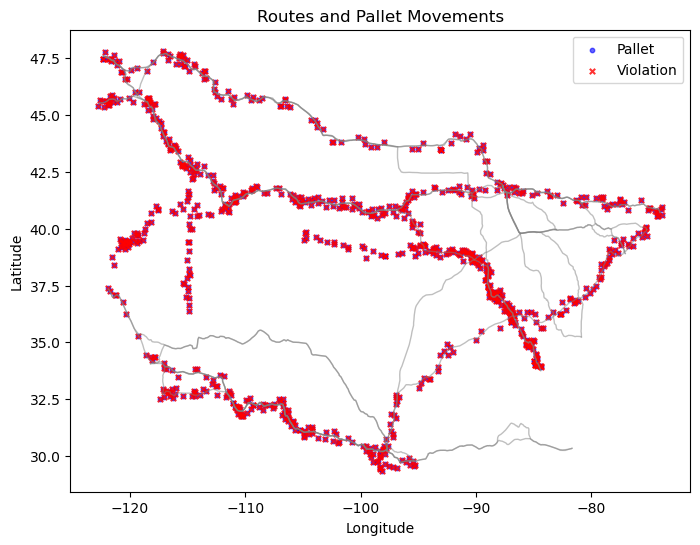

Total pallet records processed: 851
Total violations found: 851


In [8]:
import pandas as pd
import numpy as np
from collections import defaultdict
from geopy.distance import geodesic
import matplotlib.pyplot as plt

class RouteMapper:
    """
    Class to handle route building, deviation detection, and next-location prediction.
    """

    def __init__(self, threshold=150.0):
        """
        Initialize the RouteMapper with a distance threshold (in meters).
        
        Parameters
        ----------
        threshold : float
            The distance (in meters) above which we consider a pallet to be deviating
            from the matched route.
        """
        self.threshold = threshold
        self.route_dict = {}  # route_id -> list of (timestamp, lat, lon)
    
    def build_route_dict(self, historical_df):
        """
        Build an internal dictionary of routes from the historical DataFrame.
        
        Parameters
        ----------
        historical_df : pd.DataFrame
            Must have columns: ["Route_ID", "timestamp", "latitude", "longitude"].
        """
        # Convert to datetime if not already
        if not np.issubdtype(historical_df["timestamp"].dtype, np.datetime64):
            historical_df["timestamp"] = pd.to_datetime(historical_df["timestamp"])

        # Group points by Route_ID
        route_dict = defaultdict(list)
        for _, row in historical_df.iterrows():
            rid = row["Route_ID"]
            t = row["timestamp"]
            lat = row["latitude"]
            lon = row["longitude"]
            route_dict[rid].append((t, lat, lon))
        
        # Sort each route by timestamp
        for rid in route_dict:
            route_dict[rid].sort(key=lambda x: x[0])
        
        self.route_dict = dict(route_dict)

    def _haversine_distance(self, lat1, lon1, lat2, lon2):
        """
        Calculate the geodesic distance between two lat-lon points (in meters).
        """
        return geodesic((lat1, lon1), (lat2, lon2)).meters

    def _get_nearest_route_and_index(self, lat, lon):
        """
        Find the route and index within that route's points that yields the minimal 
        distance to (lat, lon). 
        
        This ignores timestamp for matching—it's purely spatial.

        Returns
        -------
        tuple
            (best_route_id, min_dist, best_index)
            best_route_id : str or None
                The route with the minimal distance
            min_dist : float
                The minimal distance found
            best_index : int
                The index within the route's list of points that is closest to (lat, lon)
        """
        best_route_id = None
        best_index = -1
        min_dist = float('inf')

        for route_id, points in self.route_dict.items():
            for i, (t, rlat, rlon) in enumerate(points):
                dist = self._haversine_distance(lat, lon, rlat, rlon)
                if dist < min_dist:
                    min_dist = dist
                    best_route_id = route_id
                    best_index = i

        return best_route_id, min_dist, best_index

    def detect_deviation(self, lat, lon):
        """
        Check if the current pallet position (lat, lon) is deviating from 
        all possible routes by more than self.threshold.

        Returns
        -------
        (route_id, dist, is_deviating)
            route_id : str or None
                The route the pallet is closest to (by pure spatial distance).
            dist : float
                The distance to that route's nearest point.
            is_deviating : bool
                True if dist > self.threshold, else False.
        """
        route_id, dist, idx = self._get_nearest_route_and_index(lat, lon)
        if route_id is None:
            # No routes found at all
            return (None, float('inf'), True)
        
        deviating = (dist > self.threshold)
        return (route_id, dist, deviating)

    def predict_next_location(self, route_id, lat, lon, current_time=None):
        """
        Predict the next location (timestamp, lat, lon) along the given route, 
        based on how the historical route progressed in time.
        
        We:
          1. Find the nearest point on the route (index = i).
          2. If there's a next point (i+1), we compute how long it took historically
             to travel from i to i+1. We then assume the pallet will follow the
             same time offset from 'current_time'.
          3. Return the predicted (next_time, next_lat, next_lon).
        
        If route_id is None or the route has no next point, return (None, None, None).
        
        Parameters
        ----------
        route_id : str
            The route to use (already matched in detect_deviation).
        lat : float
            Current pallet latitude.
        lon : float
            Current pallet longitude.
        current_time : pd.Timestamp or None
            The "real" current time for the pallet. If None, 
            we'll just use the route's next timestamp from the historical data 
            with no offset.

        Returns
        -------
        (pred_time, pred_lat, pred_lon)
            pred_time : pd.Timestamp or None
            pred_lat : float or None
            pred_lon : float or None
        """
        if route_id not in self.route_dict:
            return (None, None, None)

        points = self.route_dict[route_id]
        if not points:
            return (None, None, None)

        # 1. Find nearest route point in pure spatial sense
        best_index = -1
        min_dist = float('inf')
        for i, (rt, rlat, rlon) in enumerate(points):
            dist = self._haversine_distance(lat, lon, rlat, rlon)
            if dist < min_dist:
                min_dist = dist
                best_index = i

        # 2. If there's a next point, compute the predicted next location
        if best_index >= 0 and best_index < len(points) - 1:
            t1, lat1, lon1 = points[best_index]
            t2, lat2, lon2 = points[best_index + 1]

            # Historical time difference
            dt = (t2 - t1).total_seconds()
            if dt <= 0:
                # No forward time; fallback
                return (t2, lat2, lon2)

            # If we have a current_time, we add dt to that
            if current_time is not None:
                pred_time = current_time + pd.Timedelta(seconds=dt)
            else:
                # If no real current_time, just return the route's next timestamp
                pred_time = t2

            # We assume the route was traveled linearly in that dt
            # => the "next location" is just the next route point lat2, lon2
            # If you want partial interpolation, you could do more logic here.
            return (pred_time, lat2, lon2)
        else:
            # We are at or beyond the last point
            # Return the last point
            t_last, lat_last, lon_last = points[-1]
            return (t_last, lat_last, lon_last)

# -------------------------------------------------------------------
# PLOTTING HELPER
# -------------------------------------------------------------------
def plot_routes_and_pallets(historical_df, ongoing_df, violated_df=None):
    """
    Simple visualization of routes (in gray) and ongoing pallet points (in blue),
    and optionally the violated points (in red) if a violations DataFrame is given.
    """
    plt.figure(figsize=(8, 6))
    
    # Plot historical routes (in gray) by grouping them
    for route_id, group in historical_df.groupby("Route_ID"):
        group_sorted = group.sort_values("timestamp")
        plt.plot(group_sorted["longitude"], group_sorted["latitude"], 
                 color="gray", alpha=0.5, linewidth=1, label="_nolabel_")
    
    # Plot ongoing pallet points (in blue)
    plt.scatter(ongoing_df["longitude"], ongoing_df["latitude"], 
                color="blue", s=10, alpha=0.6, label="Pallet")
    
    # If violations DataFrame is provided, plot them in red
    if violated_df is not None and not violated_df.empty:
        plt.scatter(violated_df["longitude"], violated_df["latitude"], 
                    color="red", s=15, alpha=0.8, marker="x", label="Violation")
    
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Routes and Pallet Movements")
    # Only show legend for non-duplicate labels
    handles, labels = plt.gca().get_legend_handles_labels()
    unique = list(dict(zip(labels, handles)).items())
    plt.legend([x[1] for x in unique], [x[0] for x in unique])
    plt.show()

def export_pallet_to_route_mapping(results_df, output_file="pallet_route_mapping.csv"):
    """
    Export a CSV showing which Pallet_ID is matched to which Route_ID (plus other fields).
    
    We assume `results_df` has at least: ["Pallet_ID", "matched_route"].
    """
    mapping_df = results_df.copy()

    # Remove duplicates so each (Pallet_ID, matched_route) is listed once
    mapping_df = mapping_df.drop_duplicates(subset=["Pallet_ID", "matched_route"])

    mapping_df.to_csv(output_file, index=False)
    print(f"Exported {len(mapping_df)} unique pallet-to-route mappings to {output_file}")

# -------------------------------------------------------------------
# MAIN SCRIPT / EXAMPLE USAGE
# -------------------------------------------------------------------
def main():
    # 1. Load data
    historical_data = pd.read_csv("known_route_repo.csv")
    ongoing_data = pd.read_csv("On-going trip data.csv")

    # Convert timestamps to datetime (for the historical route)
    historical_data["timestamp"] = pd.to_datetime(historical_data["timestamp"])
    # You may or may not need to convert ongoing_data's timestamps. 
    # It's optional for anomaly detection in this scenario, 
    # but let's convert anyway if we want to predict next location times:
    ongoing_data["timestamp"] = pd.to_datetime(ongoing_data["timestamp"])

    # 2. Create RouteMapper with a threshold
    mapper = RouteMapper(threshold=150.0)
    mapper.build_route_dict(historical_data)

    violations = []
    results = []

    # 3. Iterate over ongoing data and check each pallet location
    for idx, row in ongoing_data.iterrows():
        pid = row["Pallet_ID"]
        plat = row["latitude"]
        plon = row["longitude"]
        ptime = row["timestamp"]  # We can use this for next location prediction

        # (A) Detect deviation ignoring time
        route_id, dist, is_dev = mapper.detect_deviation(plat, plon)

        # (B) Predict next location using route's historical timing
        if route_id is not None:
            pred_t, pred_lat, pred_lon = mapper.predict_next_location(route_id, plat, plon, current_time=ptime)
        else:
            pred_t, pred_lat, pred_lon = (None, None, None)

        # Record
        results.append({
            "Pallet_ID": pid,
            "timestamp": ptime,
            "latitude": plat,
            "longitude": plon,
            "matched_route": route_id,
            "distance_to_route": dist,
            "is_deviating": is_dev,
            "pred_timestamp": pred_t,
            "pred_lat": pred_lat,
            "pred_lon": pred_lon
        })

        if is_dev:
            violations.append({
                "Pallet_ID": pid,
                "timestamp": ptime,
                "latitude": plat,
                "longitude": plon,
                "dist": dist,
                "Route_ID": route_id
            })

    # 4. Convert to DataFrame, export
    results_df = pd.DataFrame(results)
    violations_df = pd.DataFrame(violations)
    
    # Save or print
    results_df.to_csv("full_results.csv", index=False)
    violations_df.to_csv("violations.csv", index=False)
    export_pallet_to_route_mapping(results_df, "pallet_route_mapping.csv")

    # 5. Plot
    plot_routes_and_pallets(historical_data, ongoing_data, violations_df)

    print(f"Total pallet records processed: {len(ongoing_data)}")
    print(f"Total violations found: {len(violations_df)}")


if __name__ == "__main__":
    main()


Saved next_locations_per_pallet.csv with predictions for each pallet's latest timestamp.
Total pallet records: 851
Total violations: 847
Exported 813 unique pallet-to-route mappings to pallet_route_mapping.csv


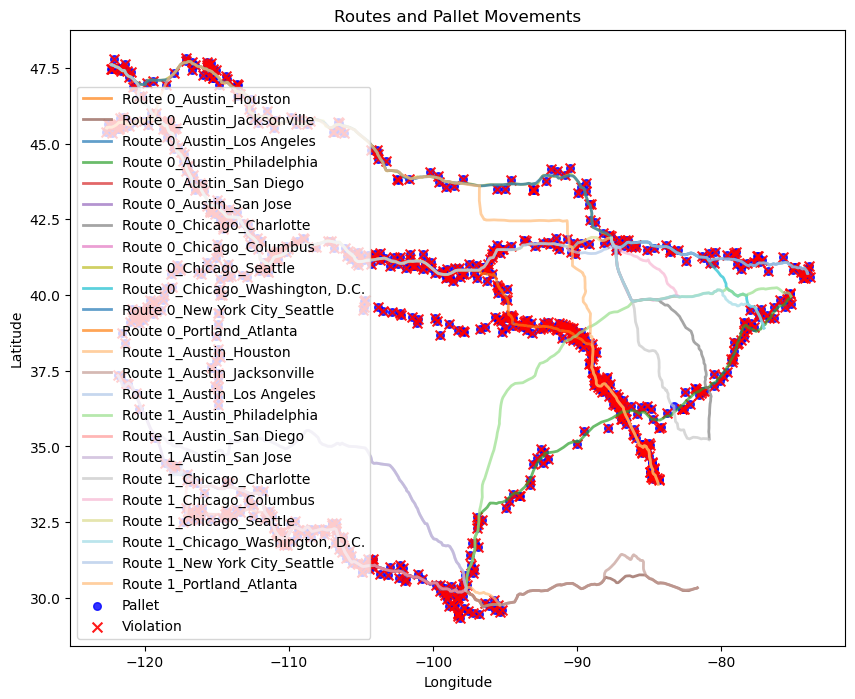

In [9]:
import pandas as pd
import numpy as np
from collections import defaultdict
from geopy.distance import geodesic
import matplotlib.pyplot as plt

class RouteMapper:
    """
    Class to handle route building, deviation detection, 
    and next-location prediction (purely spatial matching).
    """

    def __init__(self, threshold=500.0):
        """
        Initialize the RouteMapper with a distance threshold (in meters).
        
        Parameters
        ----------
        threshold : float
            The distance (in meters) above which we consider a pallet to be deviating
            from the matched route.
        """
        self.threshold = threshold
        self.route_dict = {}  # route_id -> list of (timestamp, lat, lon)
    
    def build_route_dict(self, historical_df):
        """
        Build an internal dictionary of routes from the historical DataFrame.
        
        Parameters
        ----------
        historical_df : pd.DataFrame
            Must have columns: ["Route_ID", "timestamp", "latitude", "longitude"].
        """
        # Convert to datetime if not already
        if not np.issubdtype(historical_df["timestamp"].dtype, np.datetime64):
            historical_df["timestamp"] = pd.to_datetime(historical_df["timestamp"])

        # Group points by Route_ID
        route_dict = defaultdict(list)
        for _, row in historical_df.iterrows():
            rid = row["Route_ID"]
            t = row["timestamp"]
            lat = row["latitude"]
            lon = row["longitude"]
            route_dict[rid].append((t, lat, lon))
        
        # Sort each route by timestamp
        for rid in route_dict:
            route_dict[rid].sort(key=lambda x: x[0])
        
        self.route_dict = dict(route_dict)

    def _haversine_distance(self, lat1, lon1, lat2, lon2):
        """Calculate the geodesic distance (m) between two lat-lon points."""
        return geodesic((lat1, lon1), (lat2, lon2)).meters

    def _get_nearest_route_and_index(self, lat, lon):
        """
        Find the route and index that yields the minimal distance to (lat, lon) 
        ignoring timestamps (purely spatial).

        Returns
        -------
        (best_route_id, min_dist, best_index)
        """
        best_route_id = None
        best_index = -1
        min_dist = float('inf')

        # Loop all routes
        for route_id, points in self.route_dict.items():
            # For each route, loop points
            for i, (t, rlat, rlon) in enumerate(points):
                dist = self._haversine_distance(lat, lon, rlat, rlon)
                if dist < min_dist:
                    min_dist = dist
                    best_route_id = route_id
                    best_index = i

        return best_route_id, min_dist, best_index

    def detect_deviation(self, lat, lon):
        """
        Check if the current pallet position (lat, lon) is deviating from 
        the nearest route by more than self.threshold.

        Returns
        -------
        (route_id, dist, is_deviating)
        """
        route_id, dist, idx = self._get_nearest_route_and_index(lat, lon)
        if route_id is None:
            return (None, float('inf'), True)
        
        deviating = (dist > self.threshold)
        return (route_id, dist, deviating)

    def predict_next_location(self, route_id, lat, lon, current_time=None):
        """
        Predict the next location along the given route, 
        based on how the historical route progressed in time.

        1) Find the nearest point (index i).
        2) If i+1 exists, compute how long it took historically (t2 - t1),
           add that dt to current_time.
        3) Return (pred_time, pred_lat, pred_lon).

        If route_id is None or the route has no next point, returns (None, None, None).
        """
        if route_id not in self.route_dict:
            return (None, None, None)

        points = self.route_dict[route_id]
        if not points:
            return (None, None, None)

        # 1. Find nearest route point (purely spatial)
        best_index = -1
        min_dist = float('inf')
        for i, (rt, rlat, rlon) in enumerate(points):
            dist = self._haversine_distance(lat, lon, rlat, rlon)
            if dist < min_dist:
                min_dist = dist
                best_index = i

        if best_index < 0:
            return (None, None, None)

        # 2. If there's a next point, compute next location
        if best_index < len(points) - 1:
            t1, lat1, lon1 = points[best_index]
            t2, lat2, lon2 = points[best_index + 1]
            dt = (t2 - t1).total_seconds()
            if dt < 0:
                # No forward time; fallback
                return (t2, lat2, lon2)

            # If we have current_time, add dt
            if current_time is not None:
                pred_time = current_time + pd.Timedelta(seconds=dt)
            else:
                pred_time = t2

            return (pred_time, lat2, lon2)
        else:
            # We are at or beyond the last route point
            t_last, lat_last, lon_last = points[-1]
            return (t_last, lat_last, lon_last)

def plot_routes_and_pallets(
    historical_df, 
    ongoing_df, 
    violated_df=None, 
    color_by_route=True
):
    """
    Visualize routes on a map:
      - If color_by_route=True, each route is plotted in a different color.
      - Otherwise, routes are plotted in gray.
      - Ongoing pallet points are in blue, violations in red (if any).

    Parameters
    ----------
    historical_df : pd.DataFrame
        Has columns ["Route_ID", "timestamp", "latitude", "longitude"].
    ongoing_df : pd.DataFrame
        Has columns ["Pallet_ID", "timestamp", "latitude", "longitude"].
    violated_df : pd.DataFrame or None
        Has columns ["Pallet_ID", "timestamp", "latitude", "longitude", "dist", "Route_ID"].
    color_by_route : bool
        If True, each route ID is given a distinct color.
    """
    plt.figure(figsize=(20, 10))

    # Plot historical routes
    if color_by_route:
        unique_routes = historical_df["Route_ID"].unique()
        # pick a colormap, e.g., tab20 for up to 20 distinct colors
        cmap = plt.get_cmap("tab20")
        route_color_map = {}
        for i, rid in enumerate(unique_routes):
            route_color_map[rid] = cmap(i % 20)

        for route_id, group in historical_df.groupby("Route_ID"):
            group_sorted = group.sort_values("timestamp")
            clr = route_color_map[route_id]
            plt.plot(
                group_sorted["longitude"], 
                group_sorted["latitude"], 
                color=clr, alpha=0.7, linewidth=2, label=f"Route {route_id}"
            )
    else:
        # single color (gray) for all routes
        for route_id, group in historical_df.groupby("Route_ID"):
            group_sorted = group.sort_values("timestamp")
            plt.plot(group_sorted["longitude"], group_sorted["latitude"], 
                     color="gray", alpha=0.5, linewidth=1, label="_nolabel_")

    # Plot ongoing pallet points in blue
    plt.scatter(
        ongoing_df["longitude"], 
        ongoing_df["latitude"], 
        color="blue", s=30, alpha=0.8, label="Pallet"
    )
    
    # If violations DataFrame is provided, plot them in red
    if violated_df is not None and not violated_df.empty:
        plt.scatter(
            violated_df["longitude"], 
            violated_df["latitude"], 
            color="red", s=50, alpha=0.9, marker="x", label="Violation"
        )
    
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Routes and Pallet Movements")

    # Build a legend with unique labels
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    plt.legend(unique_labels.values(), unique_labels.keys(), loc="best")
    plt.show()

def export_pallet_to_route_mapping(results_df, output_file="pallet_route_mapping.csv"):
    """
    Export a CSV showing which Pallet_ID is matched to which Route_ID (plus other fields).
    
    We assume `results_df` has at least: ["Pallet_ID", "matched_route"].
    """
    mapping_df = results_df.copy()
    # Remove duplicates so each (Pallet_ID, matched_route) is listed once
    mapping_df = mapping_df.drop_duplicates(subset=["Pallet_ID", "matched_route"])
    mapping_df.to_csv(output_file, index=False)
    print(f"Exported {len(mapping_df)} unique pallet-to-route mappings to {output_file}")

def main():
    # 1. Load data
    historical_data = pd.read_csv("known_route_repo.csv")
    ongoing_data = pd.read_csv("On-going trip data.csv")

    # Convert timestamps to datetime if needed
    historical_data["timestamp"] = pd.to_datetime(historical_data["timestamp"], errors="coerce")
    ongoing_data["timestamp"] = pd.to_datetime(ongoing_data["timestamp"], errors="coerce")

    # 2. Create RouteMapper with a higher threshold, e.g., 500m
    mapper = RouteMapper(threshold=500.0)
    mapper.build_route_dict(historical_data)

    # We'll store a row in results for *each record*, 
    # but we also want a final next-loc for the latest timestamp per pallet
    all_results = []
    violations = []

    # 3. Check each row (but we won't always predict next location for each row)
    for idx, row in ongoing_data.iterrows():
        pid = row["Pallet_ID"]
        plat = row["latitude"]
        plon = row["longitude"]
        ptime = row["timestamp"]

        # Detect deviation ignoring time
        route_id, dist, is_dev = mapper.detect_deviation(plat, plon)

        # Basic record
        rec = {
            "Pallet_ID": pid,
            "timestamp": ptime,
            "latitude": plat,
            "longitude": plon,
            "matched_route": route_id,
            "distance_to_route": dist,
            "is_deviating": is_dev,
            "pred_timestamp": None,
            "pred_lat": None,
            "pred_lon": None
        }

        # If is_dev, record a violation
        if is_dev:
            violations.append({
                "Pallet_ID": pid,
                "timestamp": ptime,
                "latitude": plat,
                "longitude": plon,
                "dist": dist,
                "Route_ID": route_id
            })
        
        all_results.append(rec)

    # Convert to DataFrame
    results_df = pd.DataFrame(all_results)
    violations_df = pd.DataFrame(violations)

    # 4. Now, for the **latest** timestamp per Pallet_ID, we do next-location prediction
    # so we only store the final predicted location for each Pallet
    next_loc_records = []
    grouped = ongoing_data.groupby("Pallet_ID", as_index=False)
    for pallet_id, group in grouped:
        # pick the row with the largest timestamp
        latest_row = group.loc[group["timestamp"].idxmax()]
        lat = latest_row["latitude"]
        lon = latest_row["longitude"]
        ptime = latest_row["timestamp"]

        # find matched route *again*, ignoring time
        route_id, dist, is_dev = mapper.detect_deviation(lat, lon)
        pred_time, pred_lat, pred_lon = (None, None, None)
        if route_id is not None:
            pred_time, pred_lat, pred_lon = mapper.predict_next_location(route_id, lat, lon, current_time=ptime)

        next_loc_records.append({
            "Pallet_ID": pallet_id,
            "current_timestamp": ptime,
            "current_lat": lat,
            "current_lon": lon,
            "matched_route": route_id,
            "distance_to_route": dist,
            "is_deviating": is_dev,
            "pred_timestamp": pred_time,
            "pred_lat": pred_lat,
            "pred_lon": pred_lon
        })

    next_loc_df = pd.DataFrame(next_loc_records)
    next_loc_df.to_csv("next_locations_per_pallet.csv", index=False)
    print("Saved next_locations_per_pallet.csv with predictions for each pallet's latest timestamp.")

    # 5. Save the main results and violations
    results_df.to_csv("full_results.csv", index=False)
    violations_df.to_csv("violations.csv", index=False)
    print(f"Total pallet records: {len(results_df)}")
    print(f"Total violations: {len(violations_df)}")

    # 6. Optional: Export pallet->route mapping
    export_pallet_to_route_mapping(results_df, "pallet_route_mapping.csv")

    # 7. Visual plot of route vs pallet locations
    #    color_by_route=True => each route in a different color
    plot_routes_and_pallets(historical_data, ongoing_data, violations_df, color_by_route=True)

if __name__ == "__main__":
    main()
